In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/My Drive/DATASET.zip'  # Replace with your file's path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)  # Check the extracted files


['__MACOSX', 'DATASET']

In [3]:
import os
import cv2
import numpy as np
import json
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
import os
import json
import cv2
import numpy as np

# Paths to dataset folders
base_path = '/content/dataset/DATASET'
fake_images_path = os.path.join(base_path, '/content/dataset/DATASET/fake_cifake_images')
real_images_path = os.path.join(base_path, '/content/dataset/DATASET/real_cifake_images')
test_images_path = os.path.join(base_path, '/content/dataset/DATASET/test')

# Load the JSON files for real and fake images
fake_json_path = os.path.join(base_path, '/content/dataset/DATASET/fake_cifake_preds.json')
real_json_path = os.path.join(base_path, '/content/dataset/DATASET/real_cifake_preds.json')

# Load fake image JSON data
with open(fake_json_path, 'r') as f:
    fake_data = json.load(f)

# Load real image JSON data
with open(real_json_path, 'r') as f:
    real_data = json.load(f)

# Check the structure of the JSON files (Just to understand the data)
print(f"Fake JSON sample: {fake_data[:3]}")  # Print first 3 entries for fake
print(f"Real JSON sample: {real_data[:3]}")  # Print first 3 entries for real

# Function to load images from directory and preprocess
def load_and_preprocess_images(image_folder, json_data, image_size=(224, 224)):
    images = []
    labels = []

    for entry in json_data:
        # Image filename corresponds to the index in the JSON
        image_filename = f"{entry['index']}.png"
        image_path = os.path.join(image_folder, image_filename)

        # Read and preprocess the image (resize and normalize)
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)  # Resize to a fixed size (e.g., 224x224)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]

        images.append(img)
        labels.append(0 if entry['prediction'] == 'fake' else 1)  # 0 for fake, 1 for real

    return np.array(images), np.array(labels)

# Load and preprocess fake and real images
fake_images, fake_labels = load_and_preprocess_images(fake_images_path, fake_data)
real_images, real_labels = load_and_preprocess_images(real_images_path, real_data)

# Combine the datasets (fake and real images)
X_train = np.concatenate([fake_images, real_images], axis=0)
y_train = np.concatenate([fake_labels, real_labels], axis=0)

# Shuffle the dataset (optional but recommended)
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")


Fake JSON sample: [{'index': 1, 'prediction': 'fake'}, {'index': 2, 'prediction': 'fake'}, {'index': 3, 'prediction': 'fake'}]
Real JSON sample: [{'index': 1, 'prediction': 'real'}, {'index': 2, 'prediction': 'fake'}, {'index': 3, 'prediction': 'real'}]
Training data shape: (2000, 224, 224, 3)
Labels shape: (2000,)


In [5]:
# Load and preprocess test images
def load_test_images(test_image_folder, image_size=(224, 224)):
    test_images = []

    for image_name in os.listdir(test_image_folder):
        image_path = os.path.join(test_image_folder, image_name)

        # Read and preprocess the image (resize and normalize)
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)  # Resize to a fixed size (e.g., 224x224)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]

        test_images.append(img)

    return np.array(test_images)

# Load and preprocess test images
test_images = load_test_images(test_images_path)
print(f"Test data shape: {test_images.shape}")


Test data shape: (500, 224, 224, 3)


In [9]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize InceptionResNetV2 model with pre-trained weights (no top classification layer)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')  # Output: 1 neuron (fake or real)
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,911,649 (213.29 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Ensure the model is properly compiled
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30
)


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9192 - loss: 0.2208 - val_accuracy: 0.8702 - val_loss: 0.3637
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.9147 - loss: 0.2064 - val_accuracy: 0.8779 - val_loss: 0.3042
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.9516 - loss: 0.1481 - val_accuracy: 0.8550 - val_loss: 0.3190
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.9058 - loss: 0.2159 - val_accuracy: 0.8092 - val_loss: 0.5294
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.8940 - loss: 0.2362 - val_accuracy: 0.8321 - val_loss: 0.4555
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.9014 - loss: 0.2355 - val_accuracy: 0.8626 - val_loss: 0.3465
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.9164 - loss: 0.2231 - val_accuracy: 0.8244 - val_loss: 0.3431
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - accuracy: 0.9238 - loss: 0.2036 - val_accuracy: 0

In [20]:
# Create a validation data generator (if you want to use augmentations for validation too)
val_datagen = ImageDataGenerator()

# Train the model using both training and validation generators
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    epochs=20
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.9395 - loss: 0.1577 - val_accuracy: 0.8397 - val_loss: 0.3516
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.9611 - loss: 0.1014 - val_accuracy: 0.8015 - val_loss: 0.4465
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.9248 - loss: 0.1605 - val_accuracy: 0.8702 - val_loss: 0.4237
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.9422 - loss: 0.1369 - val_accuracy: 0.8550 - val_loss: 0.3226
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 328ms/step - accuracy: 0.9515 - loss: 0.1396 - val_accuracy: 0.8626 - val_loss: 0.3826
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.9429 - loss: 0.1306 - val_accuracy: 0.8473 - val_loss: 0.3239
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.9646 - loss: 0.1243 - val_accuracy: 0.8855 - val_loss: 0.2936
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - accuracy: 0.9511 - loss: 0.1327 - val_accuracy: 

In [22]:
# Predict the test images
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert to 0 or 1

# Create the output JSON in the required format
output_data = []
for i, pred in enumerate(test_predictions):
    output_data.append({
        "index": i + 1,  # Ensure the index starts from 1
        "prediction": "real" if pred == 1 else "fake"
    })

# Save the predictions to a JSON file
output_json_path = 'Unpredictable.json'
with open(output_json_path, 'w') as f:
    json.dump(output_data, f, indent=4)

print(f"Predictions saved to {output_json_path}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step
Predictions saved to Unpredictable.json


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Path to your test images folder
test_folder = '/content/dataset/DATASET/test'

# List all the image files in the test folder
test_image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpg') or f.endswith('.png')]

# Prepare the test images and labels (you may have labels for the test set, or it could be unlabeled)
test_images = []
for img_file in test_image_files:
    img_path = os.path.join(test_folder, img_file)
    img = image.load_img(img_path, target_size=(224, 224))  # Resizing to 224x224
    img_array = image.img_to_array(img)  # Convert to NumPy array
    test_images.append(img_array)

# Convert the list to a NumPy array
test_images = np.array(test_images)

# Normalize the images
test_images = test_images / 255.0  # Ensure the images are scaled between 0 and 1


In [24]:
predictions = model.predict(test_images)

# Convert predictions to binary labels (if necessary, e.g., 0 for fake, 1 for real)
predicted_labels = (predictions > 0.5).astype("int32")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


In [25]:
import json

output = []
for i, filename in enumerate(test_image_files):
    output.append({
        "index": i + 1,
        "prediction": "fake" if predicted_labels[i] == 0 else "real"
    })

# Save the predictions to a JSON file
with open("teamname_prediction.json", "w") as f:
    json.dump(output, f, indent=4)


In [29]:
print("Test Data Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)


Test Data Shape: (500, 224, 224, 3)
Test Labels Shape: (5,)


In [25]:
# Make predictions on the test set (500 test images)
predictions = model.predict(test_images)

# Since the model output is likely a probability (e.g., for binary classification),
# you can convert these to binary labels (0 or 1) by setting a threshold (usually 0.5).
predicted_labels = (predictions > 0.5).astype(int)

# Check the shape and a few predictions
print(f"Predicted labels shape: {predicted_labels.shape}")
print(f"First 10 predicted labels: {predicted_labels[:10]}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
Predicted labels shape: (500, 1)
First 10 predicted labels: [[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]]


In [26]:
# Evaluate the model on the training and validation data (if available)
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.9696 - loss: 0.0948
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.8328 - loss: 0.4853
Training Accuracy: 97.33%
Validation Accuracy: 84.73%


In [32]:
import json
import os

# Make predictions on the test set
predictions = model.predict(test_images)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Get filenames for test images
test_images_filenames = sorted(os.listdir(test_images_path))  # Ensure consistent order

# Create a dictionary for predictions
predictions_dict = {}

for idx, filename in enumerate(test_images_filenames):
    predictions_dict[filename] = {
        "prediction": int(predicted_labels[idx][0]),  # 0 for real, 1 for fake
    }

# Save predictions to a JSON file
output_file = 'Unpredictable.json'

with open(output_file, 'w') as f:
    json.dump(predictions_dict, f, indent=4)

print(f"Predictions saved to {output_file}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
Predictions saved to Unpredictable.json


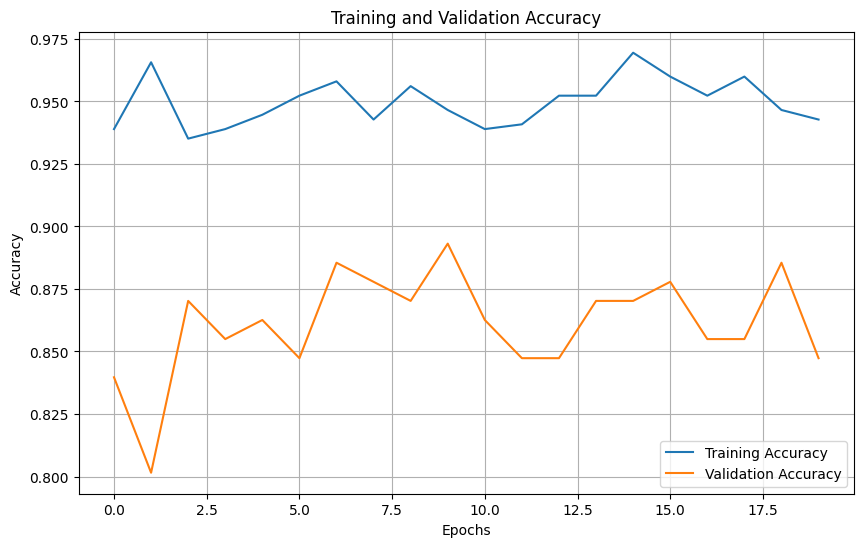

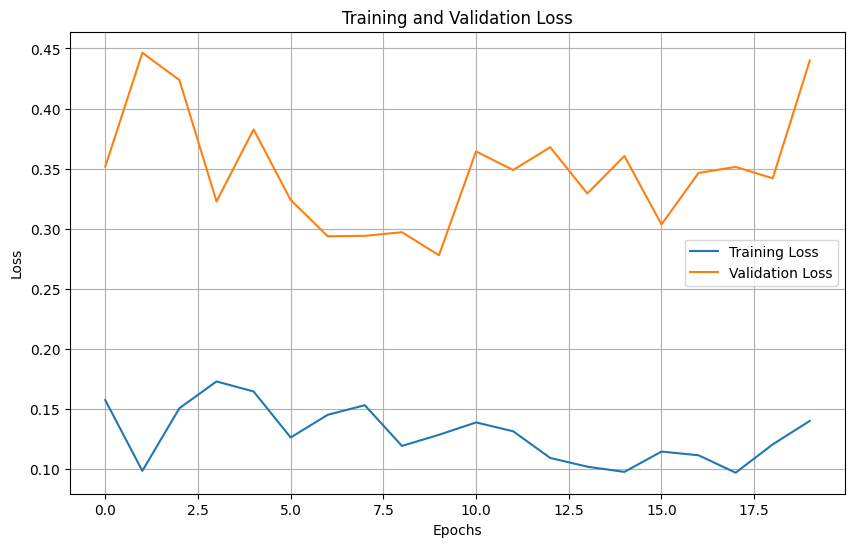

In [30]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of model.fit() from the best model

def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)
